<a href="https://colab.research.google.com/github/schwarzg/gdg_sigongmo/blob/master/schwarzg/RNN/RNN_sin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

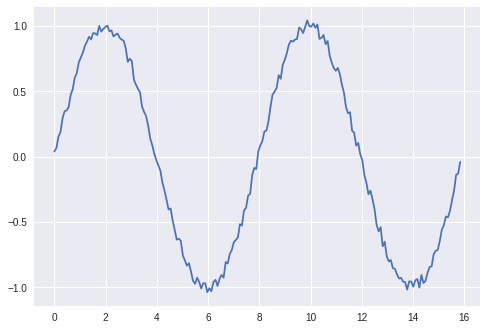

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#Prepare test data
def gen_sin(tlen,amp=0.05):
	noise=amp*np.random.uniform(low=-1,high=1,size=tlen)
	return np.sin(np.arange(0,4.*np.pi,4.*np.pi/tlen))+noise
	#return np.arange(tlen)/float(tlen)#+noise

tlen=200
sindat=gen_sin(tlen)

plt.plot(np.arange(len(sindat))/4./np.pi,sindat)
plt.show()

In [2]:
#Preprocess data
tau=25
idim=1
x_tr=[]
y_tr=[]
for i in range(0,tlen-tau):
	x_tr.append(sindat[i:i+tau])
	y_tr.append(sindat[i+tau])
X_tr=np.array(x_tr).reshape(len(x_tr),tau,idim)
Y_tr=np.array(y_tr).reshape(len(y_tr),idim)
Ndat=len(x_tr)

print X_tr.shape
print Y_tr.shape

(175, 25, 1)
(175, 1)


In [0]:
#Construct Network
#define activation functions as hypertanget function
def act(x):
	return np.tanh(x)
def dact(x):
	return 1.0-np.square(np.tanh(x))

#Feedfoward though time. the dimension of h should satisfy (tlen+1,hidden dim)
def feedfoward(x,U,W,V,b,c):
	Ndat=len(x)
	h=np.zeros((Ndat,tau+1,hdim)) #h[-1]=h[tau] means hidden in t=-1, set to zero
	z=np.zeros(h.shape)
	y=np.zeros((Ndat,idim))
	for i in range(0,tau):
		z[:,i,:]=np.dot(x[:,i,:],U)+np.dot(h[:,i-1,:],W)+b
		h[:,i,:]=act(z[:,i,:])
	#print i,"z\n",z
	#print i,"h\n",h
	y[:,:]=np.dot(h[:,tau-1,:],V)+c
	#print "y\n",y
	return [y,z,h]

#cost function : mean square error
def cost_ms(y,yt):
	return 0.5*np.mean(np.square(y-yt))

#Backpropagation through time
def BPTT(x,yt,U,W,V,b,c):
	Ndat=len(x)
	y,z,h=feedfoward(x,U,W,V,b,c)
	dEdU=np.zeros(U.shape)
	dEdW=np.zeros(W.shape)
	dEdV=np.zeros(V.shape)
	dEdb=np.zeros(b.shape)
	dEdc=np.zeros(c.shape)
	del_o=y-yt
	t=tau
	dEdV+=np.dot(h[:,t-1,:].transpose(),del_o)/Ndat
	dEdc+=np.mean(del_o,axis=0)
	del_h=np.multiply(np.dot(del_o,V.transpose()),1-h[:,t-1,:]**2)
	for i in range(t)[::-1]:
		dEdW+=np.dot(h[:,i-1,:].transpose(),del_h)/Ndat
		dEdU+=np.dot(x[:,i,:].transpose(),del_h)/Ndat
		dEdb+=np.mean(del_h,axis=0)
		del_h=np.multiply(np.dot(del_h,W.transpose()),1-h[:,i-1,:]**2)
	return [dEdU,dEdW,dEdV,dEdb,dEdc]

#Check gradient
def num_grad(x,y_t,U,W,V,b,c):
	Ndat=len(x)
	y,_,_=feedfoward(x,U,W,V,b,c)
	cost=cost_ms(y,y_t)
	ngU=np.zeros_like(U)	
	ngW=np.zeros_like(W)	
	ngV=np.zeros_like(V)	
	ngb=np.zeros_like(b)	
	ngc=np.zeros_like(c)

	d=1e-5
	for (i,j), v in np.ndenumerate(U):
		dU=np.array(U)
		dU[i,j]=v+d
		yd,_,_=feedfoward(x,dU,W,V,b,c)
		dcost=cost_ms(yd,y_t)
		ngU[i,j]=(dcost-cost)/d
	for (i,j), v in np.ndenumerate(W):
		dW=np.array(W)
		dW[i,j]=v+d
		yd,_,_=feedfoward(x,U,dW,V,b,c)
		dcost=cost_ms(yd,y_t)
		ngW[i,j]=(dcost-cost)/d
	for (i,j), v in np.ndenumerate(V):
		dV=np.array(V)
		dV[i,j]=v+d
		yd,_,_=feedfoward(x,U,W,dV,b,c)
		dcost=cost_ms(yd,y_t)
		ngV[i,j]=(dcost-cost)/d
	for (i,j), v in np.ndenumerate(b):
		db=np.array(b)
		db[i,j]=v+d
		yd,_,_=feedfoward(x,U,W,V,db,c)
		dcost=cost_ms(yd,y_t)
		ngb[i,j]=(dcost-cost)/d
	for (i,j), v in np.ndenumerate(c):
		dc=np.array(c)
		dc[i,j]=v+d
		yd,_,_=feedfoward(x,U,W,V,b,dc)
		dcost=cost_ms(yd,y_t)
		ngc[i,j]=(dcost-cost)/d
	
	return [ngU,ngW,ngV,ngb,ngc]

In [0]:
#define weight matrices, hidden nodes
hdim=10
U=0.01*np.random.normal(size=(idim,hdim))
W=0.01*np.random.normal(size=(hdim,hdim))
V=0.01*np.random.normal(size=(hdim,idim))
b=0.01*np.random.normal(size=(1,hdim))
c=0.01*np.random.normal(size=(1,idim))

In [8]:
#gradiend check
y,_,_=feedfoward(X_tr[:1,:,:],U,W,V,b,c)

A,B,C,D,E = BPTT(X_tr[:1,:,:],Y_tr[:1,:],U,W,V,b,c)
F,G,H,I,J = num_grad(X_tr[:1,:,:],Y_tr[:1,:],U,W,V,b,c)

print np.sum(A-F)
print np.sum(B-G)
print np.sum(C-H)
print np.sum(D-I)
print np.sum(E-J)

-4.8894041589455685e-09
4.5429695968726087e-10
-8.425196438297325e-09
-5.11623624336547e-09
-4.999994941523589e-06


0 0.2585336965995913 0.19726143419559397
10 0.016075794004907936 0.017718344459517203
20 0.007961979291310296 0.008871192882908345
30 0.004247223525136881 0.005228615200953855
40 0.0028364340139722236 0.004672830884057095
50 0.0025976631611056623 0.002428173566863246
60 0.0024186754461984743 0.0026411695320033715
70 0.0024182139045269635 0.001940000539073614
80 0.0022384840749506293 0.0031137028212349345
90 0.0022090684634190785 0.002924315915993647
100 0.0022775548257048944 0.0018847099639245754
110 0.0021665130450187376 0.002505345970504686
120 0.00217902091074511 0.00203826414336064
130 0.0021594190353040102 0.0019065628506860785
140 0.0020585957866857334 0.0025225709328630594
150 0.0021859286968098435 0.0010500226082998901
160 0.00203787784998909 0.002173854455688995
170 0.0020500633587254686 0.001783700426866651
180 0.002022767718605312 0.0018046254375897134
190 0.0020957194349567523 0.0009078448574194671
200 0.001929239201547869 0.0022455919353696337
210 0.0018439132788806282 0.0

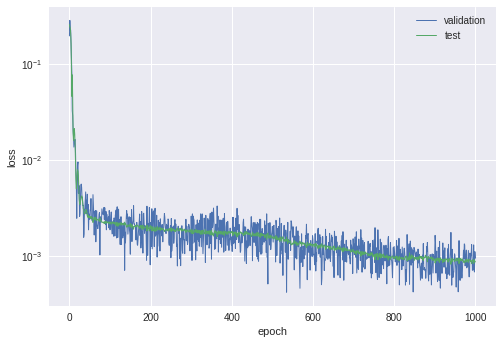

In [9]:
#start learning
nep=1000
percent=nep/100
lr=0.001

#For adam optimizer
b1=0.99
b2=0.999
mU=np.zeros_like(U)
vU=np.zeros_like(U)
mW=np.zeros_like(W)
vW=np.zeros_like(W)
mV=np.zeros_like(V)
vV=np.zeros_like(V)
mb=np.zeros_like(b)
vb=np.zeros_like(b)
mc=np.zeros_like(c)
vc=np.zeros_like(c)

tcst=[]
vcst=[]
nbat=10
nval=int(0.1*Ndat)
datpb=(Ndat-nval+1)/nbat
index=np.arange(Ndat)
for epoch in range(nep+1):
	np.random.shuffle(index)

	#Check error function
	y,_,_=feedfoward(X_tr[index[nval:],:,:],U,W,V,b,c)
	tcst.append(cost_ms(y,Y_tr[index[nval:],:]))
	yv,_,_=feedfoward(X_tr[index[:nval],:,:],U,W,V,b,c)
	vcst.append(cost_ms(yv,Y_tr[index[:nval],:]))
	
	if epoch%percent is 0:
		print epoch, tcst[epoch],vcst[epoch]#,U,W,V,b,c#,gU,gW,gV,gb,gc,y[0,0],Y_tr[0,0]

	#stochastic gradient
	for batch in range(nbat):
		bst=batch*datpb

		#Get gradient : Backpropagation through time
		gU,gW,gV,gb,gc=BPTT(X_tr[index[nval+bst:nval+bst+datpb],:,:],Y_tr[index[nval+bst:nval+bst+datpb],:],U,W,V,b,c)
	
	
		#Adam optimizer
		mU=b1*mU+(1-b1)*gU
		vU=b2*vU+(1-b2)*np.square(gU)	
		mU_h=mU/(1-b1**(epoch+1))
		vU_h=vU/(1-b2**(epoch+1))
	
		mW=b1*mW+(1-b1)*gW
		vW=b2*vW+(1-b2)*np.square(gW)	
		mW_h=mW/(1-b1**(epoch+1))
		vW_h=vW/(1-b2**(epoch+1))
	
		mV=b1*mV+(1-b1)*gV
		vV=b2*vV+(1-b2)*np.square(gV)	
		mV_h=mV/(1-b1**(epoch+1))
		vV_h=vV/(1-b2**(epoch+1))
	
		mb=b1*mb+(1-b1)*gb
		vb=b2*vb+(1-b2)*np.square(gb)	
		mb_h=mb/(1-b1**(epoch+1))
		vb_h=vb/(1-b2**(epoch+1))
	
		mc=b1*mc+(1-b1)*gc
		vc=b2*vc+(1-b2)*np.square(gc)	
		mc_h=mc/(1-b1**(epoch+1))
		vc_h=vc/(1-b2**(epoch+1))
	
		#update
		U-=lr*np.divide(mU_h,np.sqrt(vU_h)+1e-8)
		W-=lr*np.divide(mW_h,np.sqrt(vW_h)+1e-8)
		V-=lr*np.divide(mV_h,np.sqrt(vV_h)+1e-8)
		b-=lr*np.divide(mb_h,np.sqrt(vb_h)+1e-8)
		c-=lr*np.divide(mc_h,np.sqrt(vc_h)+1e-8)

#Show training curve
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log')
plt.plot(np.arange(len(vcst)),vcst,lw=1,label='validation')
plt.plot(np.arange(len(tcst)),tcst,lw=1,label='test')
plt.legend()
plt.show()


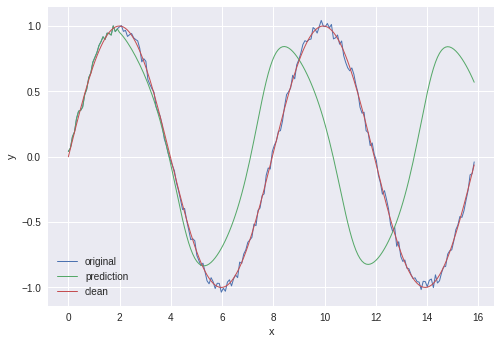

In [10]:
#Test
Ndat=1
Y_ts=X_tr[0,:,:].reshape(tau)
for i in np.arange(0,tlen-tau):
	X_ts=Y_ts[i:i+tau].reshape(1,tau,idim)
	y,_,_=feedfoward(X_ts,U,W,V,b,c)
	Y_ts=np.append(Y_ts,y)


#Show predicted data
plt.xlabel('x')
plt.ylabel('y')
plt.plot(np.arange(tlen)/(4*np.pi),sindat,lw=1,label='original')
plt.plot(np.arange(tlen)/(4*np.pi),Y_ts,lw=1,label='prediction')
plt.plot(np.arange(tlen)/(4*np.pi),np.sin(np.arange(0,4.*np.pi,4.*np.pi/tlen)),lw=1,label='clean')
plt.legend()
plt.show()